# Stable Diffusion 3.5 LoRA Fine-Tuning (Google Colab)

This notebook adapts the [`seochan99/stable-diffusion-3.5-text2image-lora`](https://github.com/seochan99/stable-diffusion-3.5-text2image-lora) project for a Colab GPU runtime. It covers dependency setup, dataset preparation, LoRA fine-tuning, and inference so you can train adapters on Google Colab GPUs.

## Prerequisites
- Accept access to the [Stable Diffusion 3.5 Medium checkpoint](https://huggingface.co/stabilityai/stable-diffusion-3.5-medium) on Hugging Face and respect the license/usage restrictions.
- Create a Hugging Face access token with **`read`** scope and keep it private.
- Prepare a dataset that follows the repository's `metadata.jsonl` format (`{"image": "images/your_image.jpg", "caption": "prompt"}`) alongside an `images/` folder.
- Launch this notebook on a Colab runtime with an NVIDIA GPU (A100/V100/3090 are ideal; T4 may require smaller settings).
- Training large diffusion models is compute intensive. Monitor VRAM usage and adjust batch size, rank, and precision as needed.

In [1]:
!nvidia-smi

Fri Oct 17 07:16:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   33C    P0             54W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Install Dependencies
Run once per runtime. Re-run after changing the Colab runtime or upgrading CUDA.

In [24]:
%%capture
%pip install -q --upgrade pip
%pip install -q --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install -q --upgrade diffusers transformers accelerate peft datasets Pillow==9.5.0 tqdm safetensors sentencepiece bitsandbytes wandb tensorboard huggingface_hub

## Authenticate with Hugging Face
Run this once per session and paste your personal access token when prompted.

In [19]:
from huggingface_hub import login
login()

## Clone the Training Repository
The notebook operates from the project root so all scripts and configs stay in sync with upstream.

In [4]:
import os
import subprocess
from pathlib import Path

repo_url = "https://github.com/seochan99/stable-diffusion-3.5-text2image-lora.git"
workspace = Path("/content")
repo_path = workspace / "stable-diffusion-3.5-text2image-lora"

if not repo_path.exists():
    subprocess.run(["git", "clone", repo_url, str(repo_path)], check=True)

os.chdir(repo_path)
print("Working directory:", Path.cwd())

Working directory: /content/stable-diffusion-3.5-text2image-lora


## (Optional) Mount Google Drive
Enable this if your dataset or output directory lives on Drive.

In [5]:
USE_DRIVE = True  # Set to True if you want to mount Google Drive

if USE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive")

Mounted at /content/drive


## Dataset Setup
Your dataset directory must contain a `metadata.jsonl` file and an `images/` subfolder. Each line in `metadata.jsonl` should look like:

```
{"image": "images/example_0001.jpg", "caption": "A serene lake at sunset"}
{"image": "images/example_0002.jpg", "caption": "Macro photo of a dewdrop on a leaf"}
```

Update the paths below to point to your dataset and the directory where you want checkpoints, logs, and LoRA weights saved.

In [6]:
from pathlib import Path

# TODO: update these paths to match your setup
DATA_ROOT = Path("/content/stable-diffusion-3.5-text2image-lora/examples/dataset")
OUTPUT_DIR = Path("/content/outputs/sd35-lora")

# Example if you mounted Drive
# DATA_ROOT = Path("/content/drive/MyDrive/datasets/my_project")
# OUTPUT_DIR = Path("/content/drive/MyDrive/experiments/sd35-lora")

DATA_ROOT.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Dataset directory:", DATA_ROOT)
print("Output directory:", OUTPUT_DIR)

Dataset directory: /content/stable-diffusion-3.5-text2image-lora/examples/dataset
Output directory: /content/outputs/sd35-lora


### Sanity-check the dataset (run after uploading files)
This cell verifies that `metadata.jsonl` and a few images exist. Skip for now if you have not uploaded any data.

In [7]:
import json
from itertools import islice

metadata_path = DATA_ROOT / "metadata.jsonl"
if metadata_path.exists():
    print("✅ Found metadata file:", metadata_path)
    with open(metadata_path, "r", encoding="utf-8") as fp:
        preview = list(islice(fp, 3))
    if preview:
        print("First metadata entries:")
        for line in preview:
            print(" ", line.strip())
else:
    print("⚠️ metadata.jsonl not found yet. Upload your dataset before training.")

images_dir = DATA_ROOT / "images"
if images_dir.exists():
    sample_images = sorted(images_dir.glob("*"))[:3]
    total_images = len(list(images_dir.glob("*")))
    print(f"Found {total_images} image files. Showing up to 3:")
    for path in sample_images:
        print(" ", path.name)
else:
    print("⚠️ images/ directory not found yet.")

✅ Found metadata file: /content/stable-diffusion-3.5-text2image-lora/examples/dataset/metadata.jsonl
First metadata entries:
  {"image": "images/image_00001.png", "caption": "A black and white photo of a map of the world"}
  {"image": "images/image_00002.png", "caption": "A computer generated image of a bunch of squares"}
  {"image": "images/image_00003.png", "caption": "A large network of people connected to each other"}
Found 13 image files. Showing up to 3:
  .gitkeep
  0_0 (1).jpeg
  0_0 (2).jpeg


## Configure Training Hyperparameters
Tweak the values below to fit your VRAM budget and dataset size. `rank`, `train_batch_size`, and precision (`bf16`/`fp16`) are the first levers to adjust when you hit memory limits.

In [ ]:
training_config = {
    "pretrained_model_name_or_path": "stabilityai/stable-diffusion-3.5-medium",
    "train_data_dir": str(DATA_ROOT),
    "output_dir": str(OUTPUT_DIR),
    "resolution": 1024,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "num_train_epochs": 10,
    "max_train_steps": None,  # Set an int to override epochs
    "rank": 64,
    "learning_rate": 1e-4,
    "text_encoder_lr": 5e-6,
    "lr_scheduler": "cosine",
    "lr_warmup_steps": 500,
    "lr_num_cycles": 1,
    "mixed_precision": "fp16",  # Switch to "fp16" if bf16 is unavailable
    "validation_prompt": "a chaotic old-fashioned real estate office interior, stressed agents on phones, messy desks covered with papers and files, phones ringing, fluorescent cold lighting, outdated furniture, tense atmosphere, nervous people, business chaos, motion blur, cinematic realism, mute",
    "validation_epochs": 2,
    "num_validation_images": 2,
    "checkpointing_steps": 500,
    "report_to": "tensorboard",
    "dataloader_num_workers": 2,
    "seed": 42,
    "precondition_outputs": 1,
}

flag_args = {
    "center_crop": False,
    "random_flip": True,
    "scale_lr": False,
    "use_8bit_adam": False,
    "gradient_checkpointing": True,
    "train_text_encoder": False,  # Enable for better alignment, but needs more VRAM
}

training_config

{'pretrained_model_name_or_path': 'stabilityai/stable-diffusion-3.5-medium',
 'train_data_dir': '/content/stable-diffusion-3.5-text2image-lora/examples/dataset',
 'output_dir': '/content/outputs/sd35-lora',
 'resolution': 1024,
 'train_batch_size': 1,
 'gradient_accumulation_steps': 4,
 'num_train_epochs': 10,
 'max_train_steps': None,
 'rank': 64,
 'learning_rate': 0.0001,
 'text_encoder_lr': 5e-06,
 'lr_scheduler': 'cosine',
 'lr_warmup_steps': 500,
 'lr_num_cycles': 1,
 'mixed_precision': 'fp16',
 'validation_prompt': 'a cinematic portrait of a corgi wearing sunglasses, 85mm lens, golden hour lighting',
 'validation_epochs': 2,
 'num_validation_images': 2,
 'checkpointing_steps': 500,
 'report_to': 'tensorboard',
 'dataloader_num_workers': 2,
 'seed': 42,
 'precondition_outputs': 1}

## Launch Training
Set `START_TRAINING = True` after you confirm that the configuration looks correct. Training will stream logs to the output area and write checkpoints/LoRA weights into `OUTPUT_DIR`.

In [20]:
import shlex
import subprocess


def build_command(config: dict, flags: dict) -> list[str]:
    cmd = ["python", "train_text_to_image_lora_sd35.py"]
    for key, value in config.items():
        if value is None:
            continue
        cmd.extend([f"--{key}", str(value)])
    for key, enabled in flags.items():
        if enabled:
            cmd.append(f"--{key}")
    return cmd


def run_training(config: dict, flags: dict) -> None:
    cmd = build_command(config, flags)
    print("Launching command: ", " ".join(shlex.quote(part) for part in cmd))
    subprocess.run(cmd, check=True)


START_TRAINING = True  # Change to True when you are ready

if START_TRAINING:
    run_training(training_config, flag_args)
else:
    print("Training not started. Inspect configuration above and set START_TRAINING = True to begin.")

Launching command:  python train_text_to_image_lora_sd35.py --pretrained_model_name_or_path stabilityai/stable-diffusion-3.5-medium --train_data_dir /content/stable-diffusion-3.5-text2image-lora/examples/dataset --output_dir /content/outputs/sd35-lora --resolution 1024 --train_batch_size 1 --gradient_accumulation_steps 4 --num_train_epochs 10 --rank 64 --learning_rate 0.0001 --text_encoder_lr 5e-06 --lr_scheduler cosine --lr_warmup_steps 500 --lr_num_cycles 1 --mixed_precision fp16 --validation_prompt 'a cinematic portrait of a corgi wearing sunglasses, 85mm lens, golden hour lighting' --validation_epochs 2 --num_validation_images 2 --checkpointing_steps 500 --report_to tensorboard --dataloader_num_workers 2 --seed 42 --precondition_outputs 1 --random_flip --gradient_checkpointing


CalledProcessError: Command '['python', 'train_text_to_image_lora_sd35.py', '--pretrained_model_name_or_path', 'stabilityai/stable-diffusion-3.5-medium', '--train_data_dir', '/content/stable-diffusion-3.5-text2image-lora/examples/dataset', '--output_dir', '/content/outputs/sd35-lora', '--resolution', '1024', '--train_batch_size', '1', '--gradient_accumulation_steps', '4', '--num_train_epochs', '10', '--rank', '64', '--learning_rate', '0.0001', '--text_encoder_lr', '5e-06', '--lr_scheduler', 'cosine', '--lr_warmup_steps', '500', '--lr_num_cycles', '1', '--mixed_precision', 'fp16', '--validation_prompt', 'a cinematic portrait of a corgi wearing sunglasses, 85mm lens, golden hour lighting', '--validation_epochs', '2', '--num_validation_images', '2', '--checkpointing_steps', '500', '--report_to', 'tensorboard', '--dataloader_num_workers', '2', '--seed', '42', '--precondition_outputs', '1', '--random_flip', '--gradient_checkpointing']' returned non-zero exit status 1.

In [22]:
!python train_text_to_image_lora_sd35.py --pretrained_model_name_or_path stabilityai/stable-diffusion-3.5-medium --train_data_dir /content/stable-diffusion-3.5-text2image-lora/examples/dataset --output_dir /content/outputs/sd35-lora --resolution 1024 --train_batch_size 1 --gradient_accumulation_steps 4 --num_train_epochs 10 --rank 64 --learning_rate 0.0001 --text_encoder_lr 5e-06 --lr_scheduler cosine --lr_warmup_steps 500 --lr_num_cycles 1 --mixed_precision bf16 --validation_prompt 'a cinematic portrait of a corgi wearing sunglasses, 85mm lens, golden hour lighting' --validation_epochs 2 --num_validation_images 2 --checkpointing_steps 500 --report_to tensorboard --dataloader_num_workers 2 --seed 42 --precondition_outputs 1 --random_flip --gradient_checkpointing


2025-10-17 07:50:13.414785: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 07:50:13.432925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760687413.455121   12532 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760687413.461875   12532 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760687413.478972   12532 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### TensorBoard (optional)
Once training has produced logs, you can visualize them with TensorBoard. Uncomment and run the cell below after the `logs/` folder exists.

In [ ]:
# %load_ext tensorboard
# from pathlib import Path
# tensorboard_logdir = Path(training_config["output_dir"]) / "logs"
# print("TensorBoard logdir:", tensorboard_logdir)
# %tensorboard --logdir $tensorboard_logdir

## Resume Training from a Checkpoint
If a run stops unexpectedly, set `training_config["resume_from_checkpoint"]` to the checkpoint folder name (e.g., `"checkpoint-1500"`) or to `"latest"`, then rerun the training cell.

## Inference with the Trained LoRA
Run this after a checkpoint or the final LoRA weights exist in `OUTPUT_DIR`. Adjust the prompt to your subject/style.

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/28 [00:00<?, ?it/s]

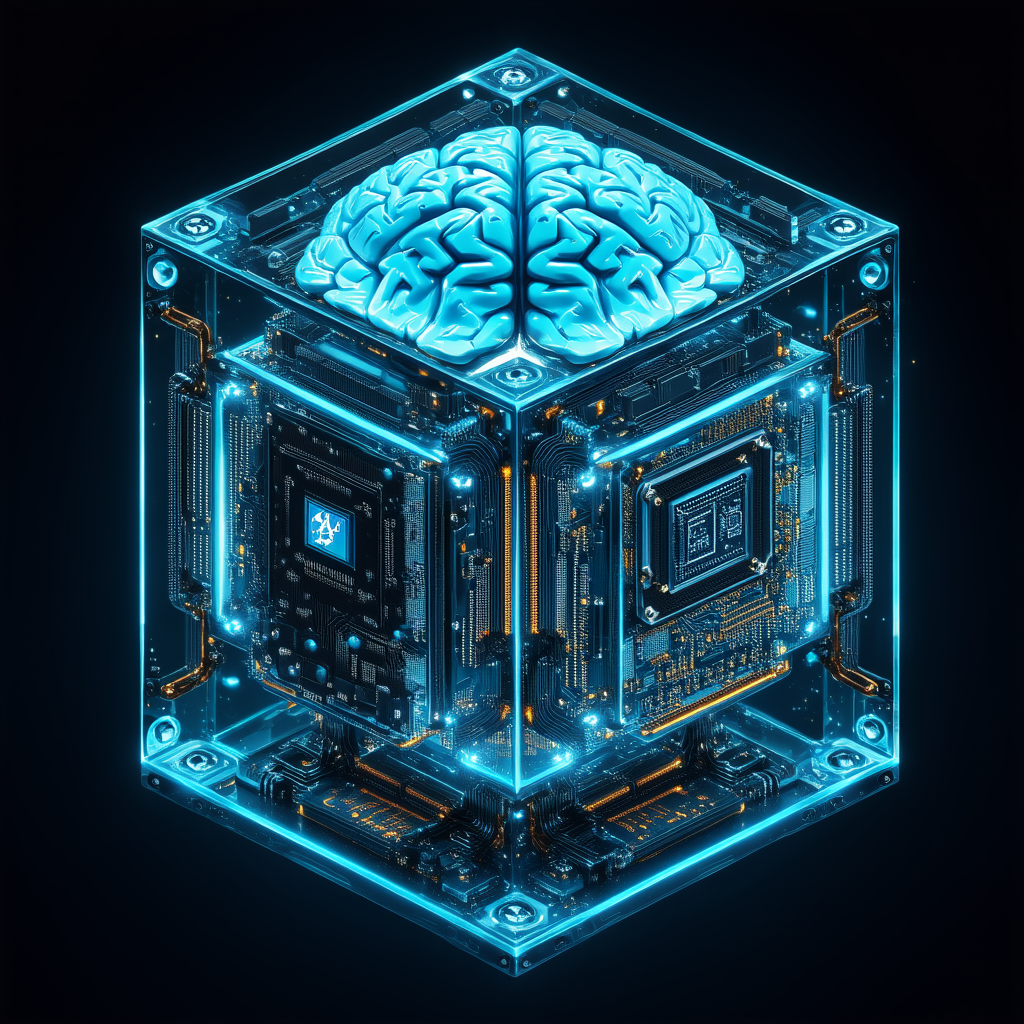

Saved sample image to /content/outputs/sd35-lora/sample_inference.png


In [26]:
import torch
from diffusers import StableDiffusion3Pipeline
from pathlib import Path
from IPython.display import display

base_model = training_config["pretrained_model_name_or_path"]
lora_dir = Path(training_config["output_dir"])

if not lora_dir.exists():
    raise FileNotFoundError(f"LoRA directory {lora_dir} does not exist yet.")

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

pipe = StableDiffusion3Pipeline.from_pretrained(
    base_model,
    torch_dtype=dtype,
)
pipe.load_lora_weights(str(lora_dir))

if device == "cuda":
    if hasattr(pipe, "enable_model_cpu_offload"):
        pipe.enable_model_cpu_offload()
    else:
        pipe.to(device)
else:
    pipe.to(device)

prompt = "brain surrounded by four modules, four glowing pathways into isometric 3d cross section of a robotic cyborg brain powered by Threat Intelligence, high tech steampunk brain, ai brain, cpu, pcb inside glass, shiny chrome, ultra detailed four glowing paths into brain, glass cube, refraction, reflections, metal parts hyper detailed, branching into four glowing paths"
negative_prompt = "blurry, distorted, low quality, bad anatomy"

result = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=28,
    guidance_scale=7.0,
)
image = result.images[0]

output_image_path = lora_dir / "sample_inference.png"
image.save(output_image_path)
display(image)
print("Saved sample image to", output_image_path)

# Clean up to free GPU memory
del pipe
if torch.cuda.is_available():
    torch.cuda.empty_cache()


### Next Steps
- Tune `rank`, `train_batch_size`, and learning rates for your subject.
- Try enabling `train_text_encoder` for higher fidelity if VRAM allows.
- Log to Weights & Biases by setting `training_config["report_to"] = "wandb"` and calling `wandb.login()` before training.
- Package the resulting LoRA by zipping `OUTPUT_DIR` or pushing it to the Hugging Face Hub with the saved adapter weights.